Zhiting Zhou 11/13/2023

In [188]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

In [189]:
# variables
brown = 0
purple = 1

time_steps = 10
num_agents = 200
monte_carlo = 50
random_seed = 1

In [190]:
# individual agent's policy
def policy(states=None, func=None, impacted_by_portion=None, confidence=None, impact_from_others=[], cost_of_state=None):
    rt_value = 0 # assume the agent returns brown if no other condition speficied
    prob_purple = 0
    
    def f(x):
        if func != None:
            result = func(x)
        else: 
            result = math.pow(x, 4)
        return result
    
    if impacted_by_portion != None:
        portion_purple = sum(states) / len(states)
        prob_purple = f(portion_purple)
    
    if confidence != None:
        if confidence > 1 or confidence < 0:
            print('confidence level need to be between 0 and 1')
        else:
            prob_purple = (1-confidence) * prob_purple
        
    # if impact_from_others.shape != 0:
    #     if impact_from_others.shape[1] != len(states):
    #         print("the length of impact should equal to the length of states")
    #     # if sum(impact_from_others) > 1:
    #     #     print("impact factros too large")
    #     else:
    #         weighted_states = impact_from_others * states
    #         prob_purple = f(weighted_states)
            
    if cost_of_state != None:
        (state, cost) = cost_of_state # state is set to be purple for now
        prob_purple = (1-cost) * prob_purple
        
    prob_brown = 1 - prob_purple    
    
    p = random.uniform(0, 1)

    if p > prob_purple:
        rt_value = 0
    else:
        rt_value = 1

    return rt_value
        
    

In [191]:
def generate_states(num_agents, num_purple=None):
    if num_purple > num_agents: # Check if the input is valid
        return "m should not be greater than n"
    states = [1] * num_purple + [0] * (num_agents - num_purple)  # List with m zeros and (n-m) ones
    random.shuffle(states)
    return states


In [192]:
def linear(x):
    return x

In [193]:
def simulation(num_agents=1000, depends_on_past_states=True, past_states=None, 
               func=None, impacted_by_portion=None, confidence=None, impact_from_others=None, cost_of_state=None):
    current_states = np.copy(past_states)
    for i in range(num_agents):
        if past_states[i] == 1: # it is already purple
            # do nothing
            current_states[i] = past_states[i]
        else:
            if depends_on_past_states:
                states = past_states
            else:
                states = current_states
                
            states = np.multiply(impact_from_others[i], states)
            state = policy(states=states, func=func, impacted_by_portion=impacted_by_portion, confidence=confidence, cost_of_state=cost_of_state)
            current_states[i] = state
            
    current_purple = sum(current_states) # how many purple we end up with
    past_purple = sum(past_states)
    increased_purple = current_purple - past_purple
    return current_states, current_purple, increased_purple

In [194]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=100)
    plt.show()


In [195]:

labels = [str(i) for i in range(num_agents)]
adjacency_0 = np.array([[0 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_1 = np.array([[1 for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_random = np.array([[random.randint(0, 1) for _ in range(num_agents)] for _ in range(num_agents)])
adjacency_identity = np.identity(num_agents)

# specify which adjacency matrix to use
adjacency = adjacency_1
# show_graph_with_labels(adjacency)

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

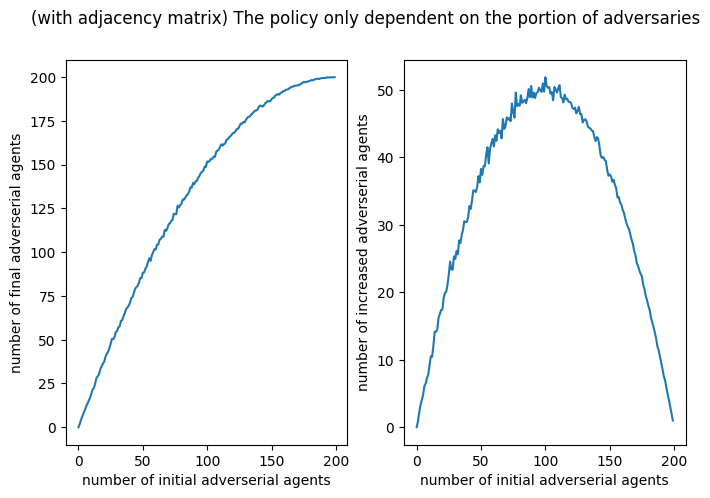

In [196]:
# single iteration simulation begins
random.seed(random_seed)
depends_on_past_states = True # if the agent's policy depends on past states or current states?
num_purple = [] # how many purple we end up with
nums = [] # keep track of how many initial purples we tested
num_portion = []
num_increase = []
for num_adv in range(num_agents):
    past_states = generate_states(num_agents=num_agents, num_purple=num_adv) # initial states: i purples, which means i adversaries
    
    # simulate for 10 times
    current_states_carlo = []
    current_purple_carlo = 0
    for iter in range(monte_carlo): 
        current_states, current_purple, increased_purple = simulation(num_agents=num_agents, depends_on_past_states=True,past_states=past_states,
                                                                      func=linear, impacted_by_portion=True, confidence=None, impact_from_others=adjacency, cost_of_state=None)
        if iter == 0:
            current_states_carlo =  np.copy(current_states)
        else:
            current_states_carlo = current_states_carlo + current_states
        current_states_carlo = np.array(current_states_carlo)
        current_purple_carlo += current_purple
        
    current_states = [round(num) for num in current_states_carlo/monte_carlo] # make sure the states are binary

    current_purple = current_purple_carlo/monte_carlo
    increased_purple = current_purple - num_adv
        
    num_purple.append(current_purple)
    nums.append(num_adv)
    num_increase.append(increased_purple)
    num_portion.append((sum(current_states) - num_adv) / (sum(past_states)+0.001))

plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase)
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')
# ax = plt.subplot(1,3,3)
# plt.plot(nums, num_portion)
# plt.xlabel("number of initial adverserial agents")
# plt.ylabel("number of increased adverserial agents")
# plt.title("the policy depends on the portion of answering purple")
    
    

In [197]:
# reward function of each agent

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

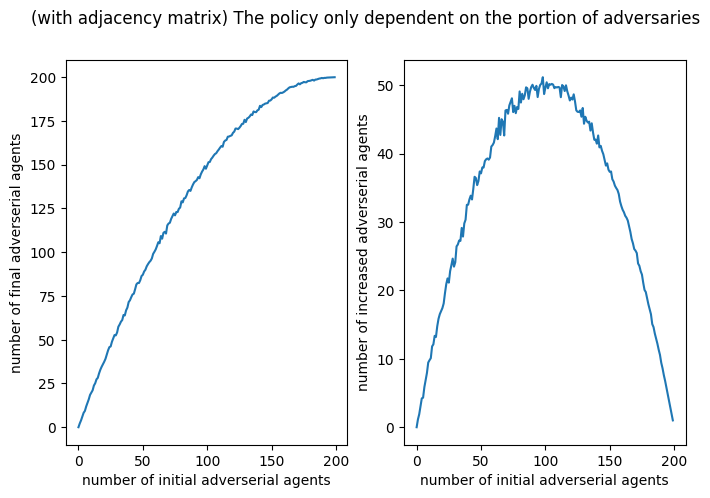

In [198]:
# time step iteration simulation begins
random.seed(random_seed)
depends_on_past_states = True # if the agent's policy depends on past states or current states?

num_purple_time = []
nums = []
num_increase_time = []

for num_adv in range(num_agents):
    initial_states = generate_states(num_agents=num_agents, num_purple=num_adv) # initial states: i purples, which means i adversaries
    prev_states = initial_states
    
    num_purple = [] # how many purple we end up wit
    num_portion = []
    num_increase = []
    
    for time in range(time_steps):
        # simulate for 10 times
        current_states_carlo = []
        current_purple_carlo = 0
        for iter in range(monte_carlo): 
            current_states, current_purple, increased_purple = simulation(num_agents=num_agents, depends_on_past_states=True,past_states=prev_states,
                                                                        func=linear, impacted_by_portion=True, confidence=None, impact_from_others=adjacency, cost_of_state=None)
            if iter == 0:
                current_states_carlo =  np.copy(current_states)
            else:
                current_states_carlo = current_states_carlo + current_states
            current_states_carlo = np.array(current_states_carlo)
            current_purple_carlo += current_purple
            
        current_states = [round(num) for num in current_states_carlo/monte_carlo] # make sure the states are binary

        current_purple = current_purple_carlo/monte_carlo
        increased_purple = current_purple - num_adv
            
        num_purple.append(current_purple)
        
        num_increase.append(increased_purple)
        num_portion.append((sum(current_states) - num_adv) / (sum(past_states)+0.001))

        prev_states = current_states
    
    nums.append(num_adv)
    num_purple_time.append(num_purple)
    num_increase_time.append(num_increase)
 
num_purple_time = np.array(num_purple_time)
num_increase_time = np.array(num_increase_time)
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 0])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 0])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')


In [199]:
print(num_purple_time.shape)
print(num_increase_time.shape)

(200, 10)
(200, 10)


Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

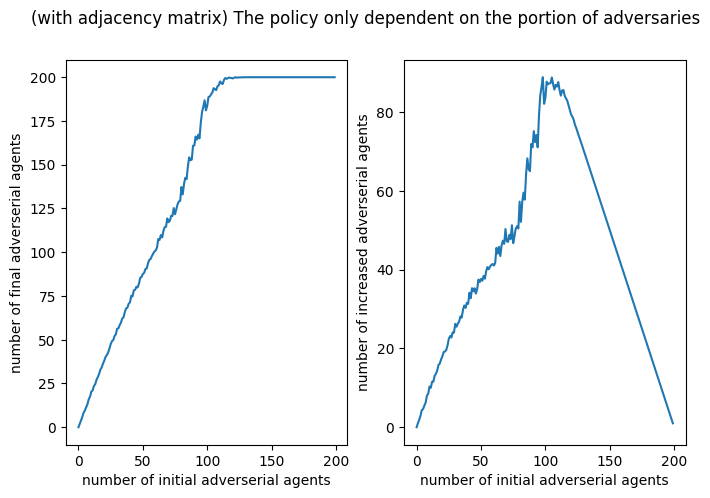

In [200]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 1])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 1])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')


Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

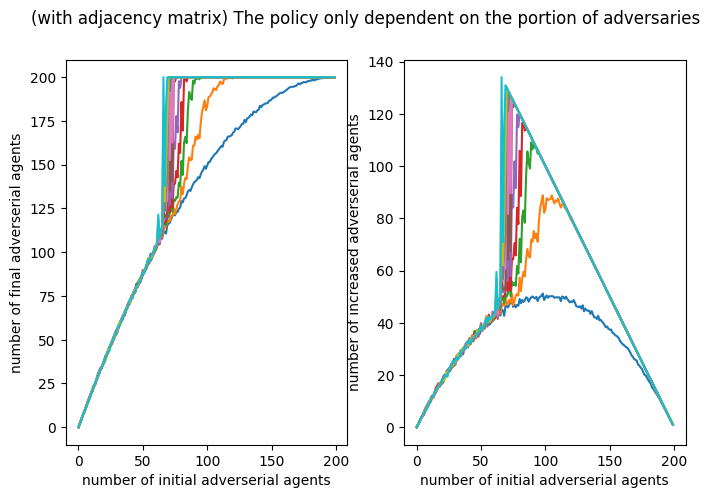

In [201]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
for time in range(time_steps):
    plt.plot(nums, num_purple_time[:, time])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
for time in range(time_steps):
    plt.plot(nums, num_increase_time[:, time])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

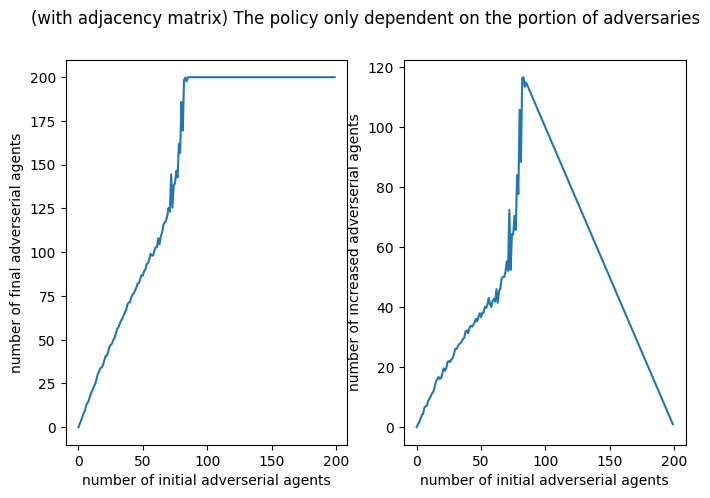

In [202]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 3])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 3])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

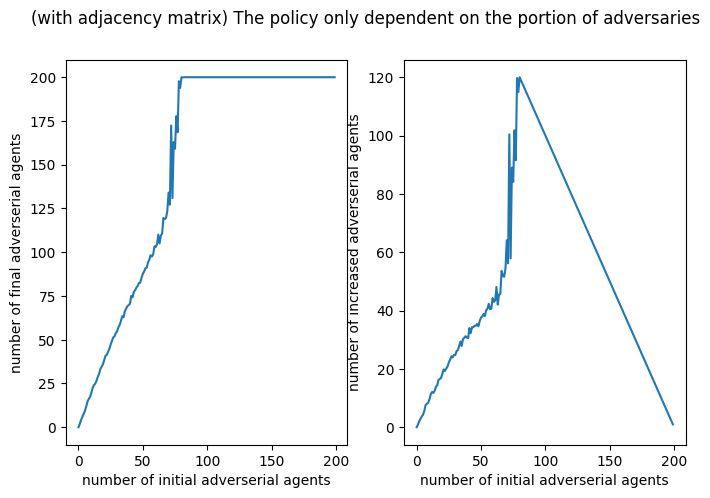

In [203]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 4])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 4])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

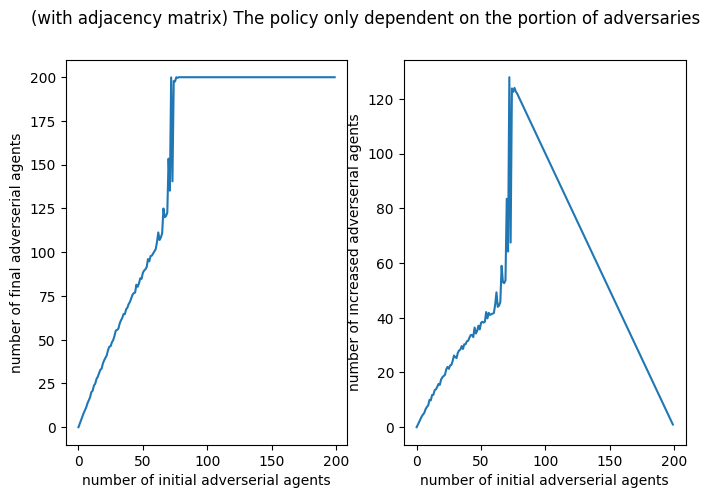

In [204]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 5])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 5])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

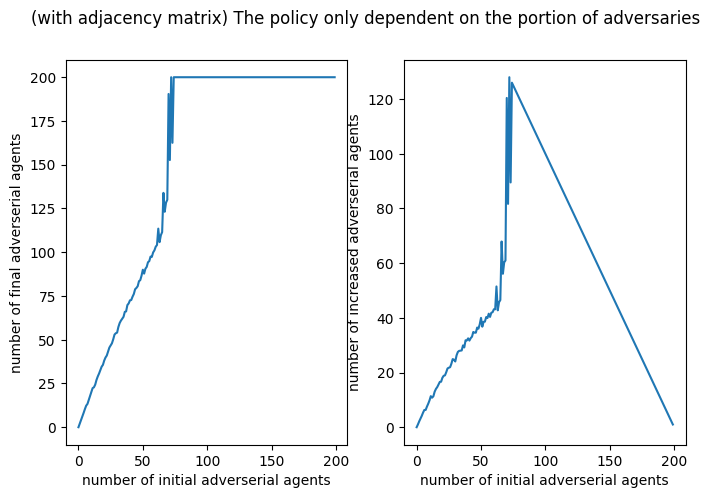

In [205]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 6])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 6])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

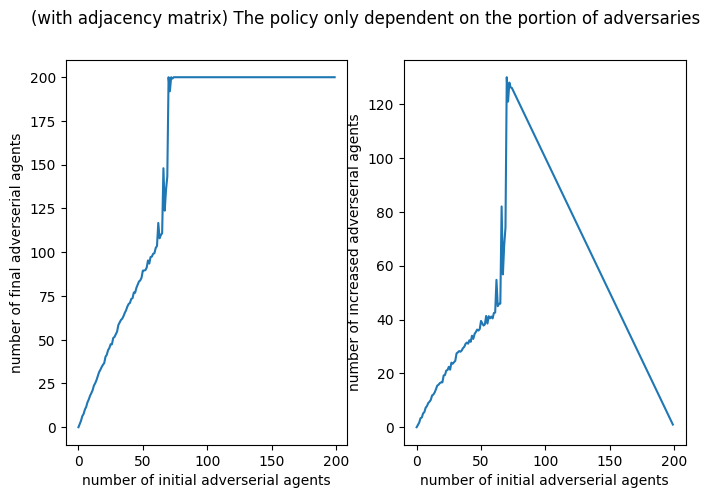

In [206]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 7])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 7])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

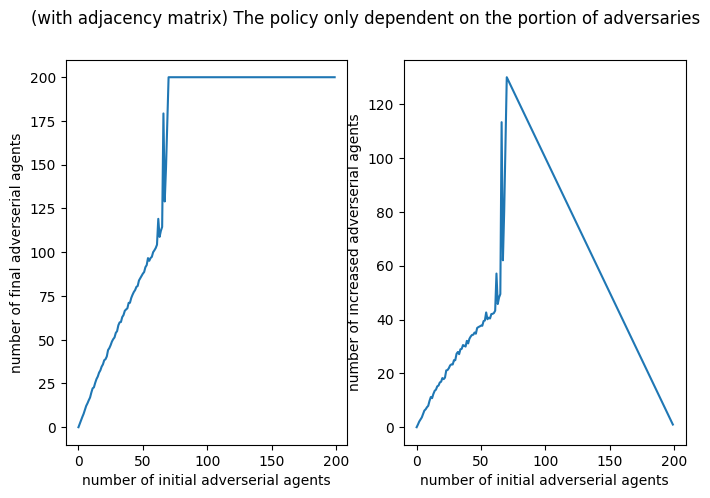

In [207]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 8])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 8])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')

Text(0.5, 0.98, '(with adjacency matrix) The policy only dependent on the portion of adversaries')

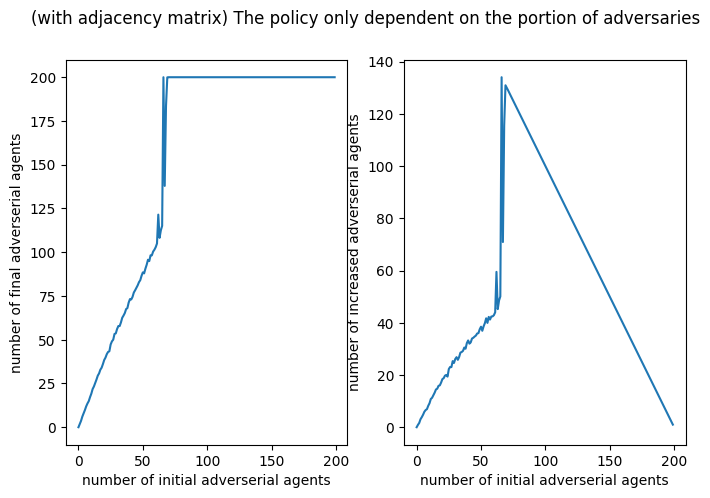

In [208]:
plt.subplots(1, 2, figsize=(8, 5))

ax = plt.subplot(1,2,1)
plt.plot(nums, num_purple_time[:, 9])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of final adverserial agents")

ax = plt.subplot(1,2,2)
plt.plot(nums, num_increase_time[:, 9])
plt.xlabel("number of initial adverserial agents")
plt.ylabel("number of increased adverserial agents")

plt.suptitle('(with adjacency matrix) The policy only dependent on the portion of adversaries')